In [1]:
!pip install segmentation-models-pytorch

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# We are going to use dataset of segmented animals
import kagglehub
import random
import os
import torch

from torch.utils.data import Dataset, DataLoader
from PIL import Image
from pathlib import Path
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
import torch.optim as optim
import torch.nn as nn
import segmentation_models_pytorch as smp

/home/shutkov/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [5]:
PATH = "" # YOUR PATH TO KAGGLE DATASET HERE
# Download latest version
path = kagglehub.dataset_download(PATH)

print("Path to dataset files:", path)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 192M/192M [00:07<00:00, 27.3MB/s]

Extracting files...


Path to dataset files: /home/shutkov/.cache/kagglehub/datasets/mohammad2012191/segmentation/versions/1


In [6]:
# Check directories in the dataset  
print("Files and Folders in Dataset Directory:", os.listdir(path))

Files and Folders in Dataset Directory: ['train', 'val']


In [7]:
# maybe layter we will use single dirrectory and split on train and val in the runtime
if set(os.listdir(path)) == set(['train', 'val']):
    tr_img_dir, tr_mask_dir = f"{path}/train/images", f"{path}/train/masks"
    val_img_dir, val_mask_dir = f"{path}/val/images", f"{path}/val/masks"
else:
    raise FileNotFoundError("Dataset is incorrect")

In [8]:
tr_img_dir

'/home/shutkov/.cache/kagglehub/datasets/mohammad2012191/segmentation/versions/1/train/images'

In [9]:
class Segmentation(Dataset):
    '''
    This Class defines our own dataloader of the kaggle dataset.
    '''
    
    def __init__(self, image_dir, mask_dir, transform=None):
        '''
        image_dir - dirrectory with images
        mask_dir - dirrectory with masks
        transform - any image transformation for data augmentation (cropp, flip, resize, filter)
        '''

        # according to dataset, images are all jpg files and masks are all png files
        self.image_paths = sorted(Path(image_dir).glob("*.jpg"))
        self.mask_paths = sorted(Path(mask_dir).glob("*.png"))
        self.transform = transform

    def __getitem__(self, idx):
        '''
        Get single image from the loaded dataset
        idx - number of image
        '''
        image = np.array(Image.open(self.image_paths[idx]).convert("RGB"))
        mask = np.array(Image.open(self.mask_paths[idx]))
        # the mask only has 5 different parts - (Tail, Body, Legs, Head, Background)
        # we want to remove any misleading values
        mask = np.clip(mask, 0, 4)

        if self.transform:
            tmp = self.transform(image=image, mask=mask)
            image, mask = tmp['image'],tmp['mask']
            
        return image, mask

    def __len__(self):
        # number of images in dataset
        return len(self.image_paths)

In [10]:
# here we are using albumentations library to get image augmentation and reduce model overfitting on our small dataset
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), # number were taken from the internet thread
    ToTensorV2()
])

# for the validation dataset, we do not apply augmentation to work with 'pure' image
val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])



In [11]:
# load dataset
train_dataset = Segmentation(tr_img_dir, tr_mask_dir, transform=train_transform)
val_dataset = Segmentation(val_img_dir, val_mask_dir, transform=val_transform)

# shuffle dataset
# in future we are going to shuffle first and then split into train and validation
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)

In [12]:
print(f"Train Samples: {len(train_dataset)}")
print(f"Validation Samples: {len(val_dataset)}")
# Here training dataset is pretty small, however hopefully we can achieve sufficient accuracy 
# We are going to use pretrained U-net model for the segmentation

Train Samples: 1737
Validation Samples: 435


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


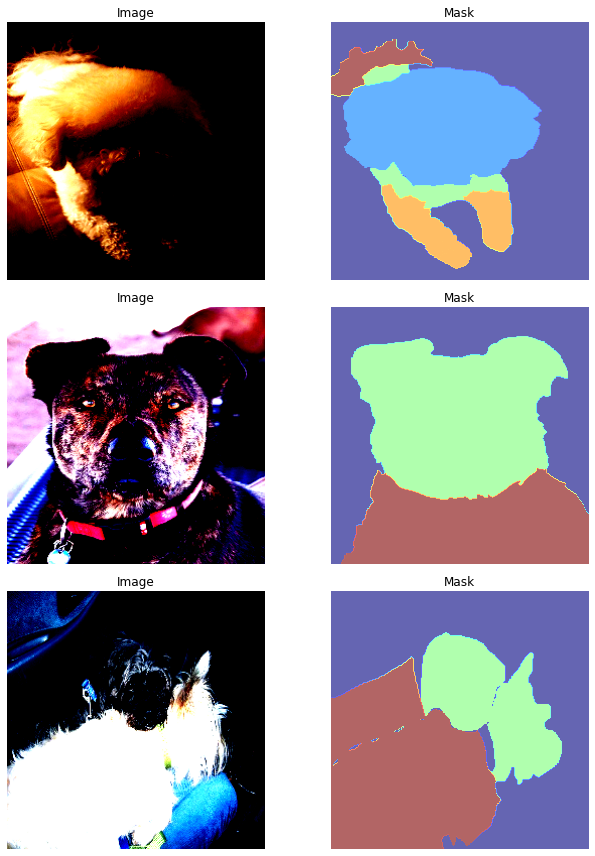

In [13]:
def draw_img(dataset, num_samples=3):
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 4))

    for i in range(num_samples):
        img, mask = dataset[random.randint(0, len(dataset) - 1)]

        img_np = img.permute(1, 2, 0).numpy()
        mask_np = mask.numpy()
        
        axes[i, 0].imshow(img_np)
        axes[i, 0].set_title("Image")

        # Show the corresponding mask
        axes[i, 1].imshow(mask_np, cmap="jet", alpha=0.6)
        axes[i, 1].set_title("Mask")

        # Remove axis labels for a cleaner look
        for ax in axes[i]:
            ax.axis("off")

    plt.tight_layout()
    plt.show()

draw_img(train_dataset)

In [14]:
# in the previous cell the images can look very strange, however it's due to augmentation techniques

In [15]:
class Model(nn.Module):
    def __init__(self, num_classes=5, encoder="efficientnet-b0", pretrained=True):
        super(Model, self).__init__()

        self.model = smp.Unet(
            encoder_name=encoder,
            encoder_weights="imagenet" if pretrained else None,
            in_channels=3,
            classes=num_classes,
        )

    def forward(self, x):
        return self.model(x)

model = Model(num_classes=5)

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


/home/shutkov/.local/lib/python3.10/site-packages/segmentation_models_pytorch/encoders/__init__.py:136: UserWarning: Error loading efficientnet-b0 `imagenet` weights from Hugging Face Hub, trying loading from original url...
  warnings.warn(message, UserWarning)


In [16]:
def train(model, dataloader, optimizer, loss_f, device):
    model.train()
    
    dataset_loss = 0.

    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device).long()

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_f(outputs, masks)
        loss.backward()
        optimizer.step()
        
        dataset_loss += loss.item()

    return dataset_loss / len(dataloader)

def test(model, dataloader, loss_f, device):
    model.eval()
    
    test_loss = 0.

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device).long()

            outputs = model(images)
            loss = loss_f(outputs, masks)
            test_loss += loss.item()

    return test_loss / len(dataloader)

In [17]:
# we are able to train on both mac and linux machines either with cuda or with mps
device = torch.device("cuda" if torch.cuda.is_available() else "mps")
print(f"Using device: {device}")
model = Model(num_classes=5).to(device)

Exception ignored in: <function tqdm.__del__ at 0x77f6343f5b40>
Traceback (most recent call last):
  File "/home/shutkov/.local/lib/python3.10/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/home/shutkov/.local/lib/python3.10/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
  File "/home/shutkov/.local/lib/python3.10/site-packages/tqdm/notebook.py", line 150, in display
    d = self.format_dict
  File "/home/shutkov/.local/lib/python3.10/site-packages/tqdm/std.py", line 1462, in format_dict
    'colour': self.colour}
  File "/home/shutkov/.local/lib/python3.10/site-packages/tqdm/notebook.py", line 195, in colour
    return self.container.children[-2].style.bar_color
AttributeError: 'FloatProgress' object has no attribute 'style'


Using device: cuda


Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 10
train_losses, val_losses = [], []

for epoch in tqdm(range(num_epochs)):
    train_loss = train(model, train_loader, optimizer, criterion, device)
    val_loss = test(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.2f} - Val Loss: {val_loss:.2f}")


  0%|                                                                                                                                                                                                                                                                                                | 0/10 [00:00<?, ?it/s]Exception ignored in: <function tqdm.__del__ at 0x77f6343f5b40>
Traceback (most recent call last):
  File "/home/shutkov/.local/lib/python3.10/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/home/shutkov/.local/lib/python3.10/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
  File "/home/shutkov/.local/lib/python3.10/site-packages/tqdm/notebook.py", line 150, in display
    d = self.format_dict
  File "/home/shutkov/.local/lib/python3.10/site-packages/tqdm/std.py", line 1462, in format_dict
    'colour': self.colour}
  File "/home/shutkov/.local/lib/python3.10/site-packages/tqdm/notebook.py",

Epoch [1/10] - Train Loss: 0.99 - Val Loss: 0.57



 20%|████████████████████████████████████████████████████████                                                                                                                                                                                                                                | 2/10 [00:38<02:34, 19.30s/it]

Epoch [2/10] - Train Loss: 0.50 - Val Loss: 0.38



 30%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                    | 3/10 [00:57<02:14, 19.21s/it]

Epoch [3/10] - Train Loss: 0.38 - Val Loss: 0.32



 40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 4/10 [01:16<01:54, 19.12s/it]

Epoch [4/10] - Train Loss: 0.33 - Val Loss: 0.30



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 5/10 [01:35<01:35, 19.07s/it]

Epoch [5/10] - Train Loss: 0.28 - Val Loss: 0.28



 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 6/10 [01:54<01:16, 19.08s/it]

Epoch [6/10] - Train Loss: 0.26 - Val Loss: 0.28



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 7/10 [02:14<00:57, 19.12s/it]

Epoch [7/10] - Train Loss: 0.25 - Val Loss: 0.26



 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 8/10 [02:33<00:38, 19.10s/it]

Epoch [8/10] - Train Loss: 0.23 - Val Loss: 0.26



 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 9/10 [02:52<00:19, 19.12s/it]

Epoch [9/10] - Train Loss: 0.22 - Val Loss: 0.25



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:11<00:00, 19.16s/it]

Epoch [10/10] - Train Loss: 0.21 - Val Loss: 0.25


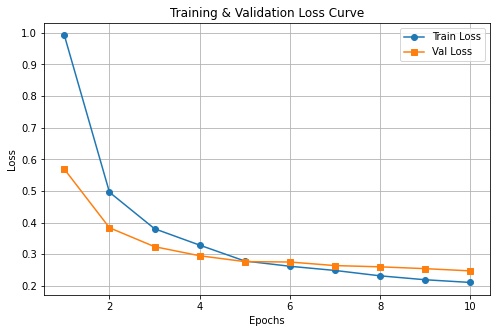

In [19]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", marker="o")
plt.plot(range(1, num_epochs + 1), val_losses, label="Val Loss", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss Curve")
plt.grid()
plt.show()

In [21]:
# save model 
PATH = "models/unet"
torch.save(model.state_dict(), PATH)